Found 109 images belonging to 4 classes.
Found 109 images belonging to 4 classes.
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 47s 16s/step - accuracy: 0.3474 - loss: 12.7693 - val_accuracy: 0.1979 - val_loss: 20.4692
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.1875 - loss: 24.1309 - val_accuracy: 0.0000e+00 - val_loss: 18.4388
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 74s 14s/step - accuracy: 0.1888 - loss: 14.0288 - val_accuracy: 0.2500 - val_loss: 9.6172
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 952ms/step - accuracy: 0.3846 - loss: 8.6110 - val_accuracy: 1.0000 - val_loss: 0.0102
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 73s 13s/step - accuracy: 0.2392 - loss: 12.9003 - val_accuracy: 0.2812 - val_loss: 8.3387
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.2500 - loss: 10.5324 - val_accuracy: 1.0000 - val_loss: 0.2641
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 72s 15s/step - accuracy: 0.2911 - loss: 7.7523 - val_accuracy: 0.1979 - val_loss: 3.7301
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


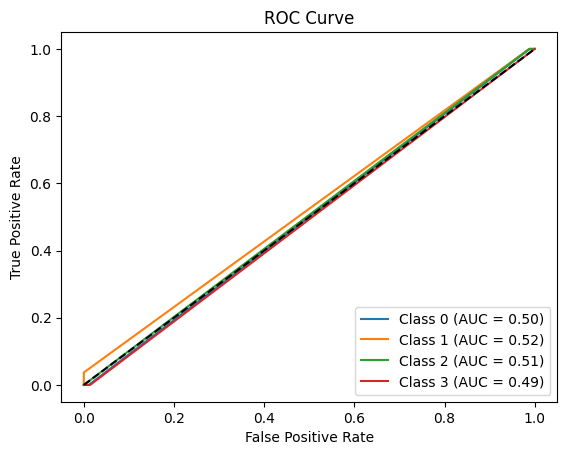

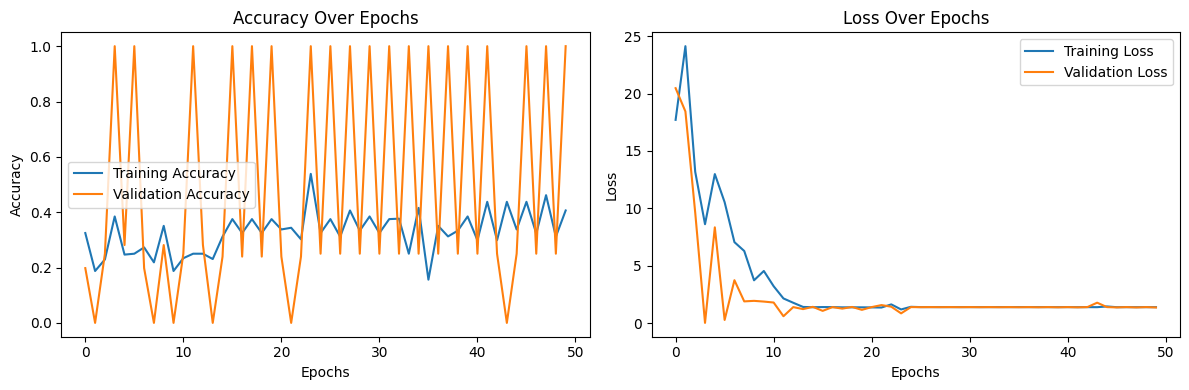

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import shutil

# Directories for training dataset
data_dir = "/content/drive/MyDrive/dataset"  # Updated dataset path
train_dir = os.path.join(data_dir, 'train')

# Image parameters
img_height = 224
img_width = 224
batch_size = 32

# Create validation set from training set
val_dir = os.path.join(data_dir, 'validation')
os.makedirs(val_dir, exist_ok=True)

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

        val_class_path = os.path.join(val_dir, class_name)
        os.makedirs(val_class_path, exist_ok=True)

        for val_image in val_images:
            shutil.move(os.path.join(class_path, val_image), os.path.join(val_class_path, val_image))

# Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load ResNet50 Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze layers

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 50
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size
)

# Evaluate Model
val_generator.reset()
predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = val_generator.classes

# Metrics
print("Classification Report")
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))

print("Confusion Matrix")
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

# ROC Curve and AUC
fpr = {}
tpr = {}
roc_auc = {}
for i in range(train_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(train_generator.num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Accuracy and Loss Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Found 86 images belonging to 4 classes.
Found 132 images belonging to 4 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 32s/step - accuracy: 0.2647 - loss: 2.2071 - val_accuracy: 0.1797 - val_loss: 1.6934 - learning_rate: 1.0000e-04
Epoch 2/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - accuracy: 0.2812 - loss: 3.1906

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 10s/step - accuracy: 0.2812 - loss: 3.1906 - val_accuracy: 0.0000e+00 - val_loss: 2.2403 - learning_rate: 1.0000e-04
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 31s/step - accuracy: 0.1291 - loss: 2.7996 - val_accuracy: 0.1875 - val_loss: 1.5540 - learning_rate: 1.0000e-04
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 610ms/step - accuracy: 0.3438 - loss: 1.9666 - val_accuracy: 0.0000e+00 - val_loss: 1.8427 - learning_rate: 1.0000e-04
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 72s 28s/step - accuracy: 0.3121 - loss: 1.8325 - val_accuracy: 0.2266 - val_loss: 1.5719 - learning_rate: 1.0000e-04
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 600ms/step - accuracy: 0.3125 - loss: 2.4408 - val_accuracy: 0.0000e+00 - val_loss: 2.2268 - learning_rate: 1.0000e-04
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 74s 31s/step - accuracy: 0.3854 - loss: 1.7537 - val_accuracy: 0.2188 - val_loss: 1.6648 - learning_rate: 1.0000e-04
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 13s/step - accuracy: 0.2727 - loss: 2.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


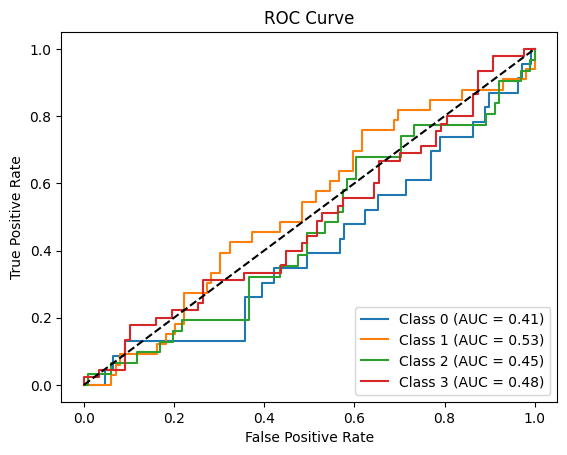

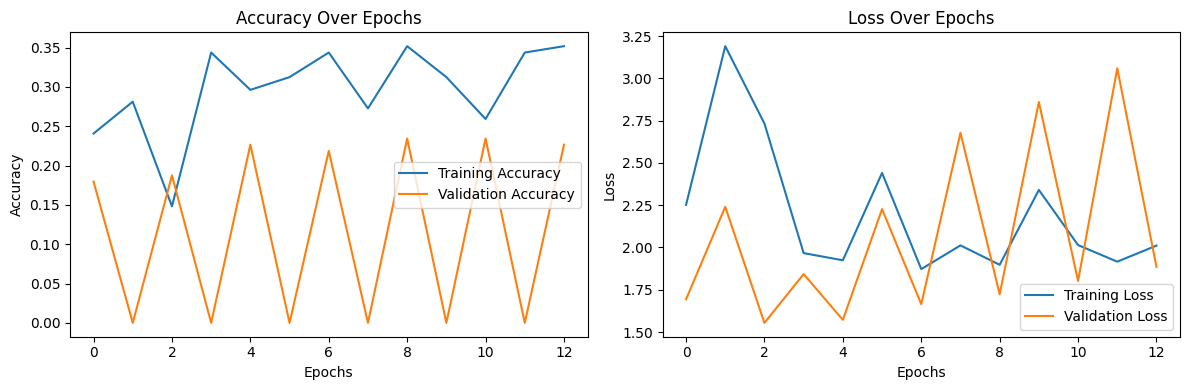

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import shutil

# Directories for training dataset
data_dir = "/content/drive/MyDrive/dataset"  # Updated dataset path
train_dir = os.path.join(data_dir, 'train')

# Image parameters
img_height = 224
img_width = 224
batch_size = 32

# Create validation set from training set
val_dir = os.path.join(data_dir, 'validation')
os.makedirs(val_dir, exist_ok=True)

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

        val_class_path = os.path.join(val_dir, class_name)
        os.makedirs(val_class_path, exist_ok=True)

        for val_image in val_images:
            shutil.move(os.path.join(class_path, val_image), os.path.join(val_class_path, val_image))

# Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load ResNet50 Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model.layers[:-20]:
    layer.trainable = False  # Freeze initial layers

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
epochs = 50
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate Model
val_generator.reset()
predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = val_generator.classes

# Metrics
print("Classification Report")
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))

print("Confusion Matrix")
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

# ROC Curve and AUC
fpr = {}
tpr = {}
roc_auc = {}
for i in range(train_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(train_generator.num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Accuracy and Loss Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Found 197 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.6010 - loss: 3.7052 - val_accuracy: 0.7292 - val_loss: 0.6163 - learning_rate: 0.0010
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.7512 - loss: 0.5611 - val_accuracy: 0.7292 - val_loss: 0.6622 - learning_rate: 0.0010
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.6811 - loss: 0.6573 - val_accuracy: 0.7292 - val_loss: 0.5621 - learning_rate: 0.0010
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.6578 - loss: 0.7115 - val_accuracy: 0.7292 - val_loss: 0.6107 - learning_rate: 0.0010
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.6931 - loss: 0.6048 - val_accuracy: 0.7292 - val_loss: 0.5832 - learning_rate: 0.0010
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.7835 - loss: 0.5453 - val_accuracy: 0.7292 - val_loss: 0.5877 - learning_rate: 0.0010
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.7520 - loss: 0.5852 - val_accuracy: 0.7292 - val_loss: 0.5876

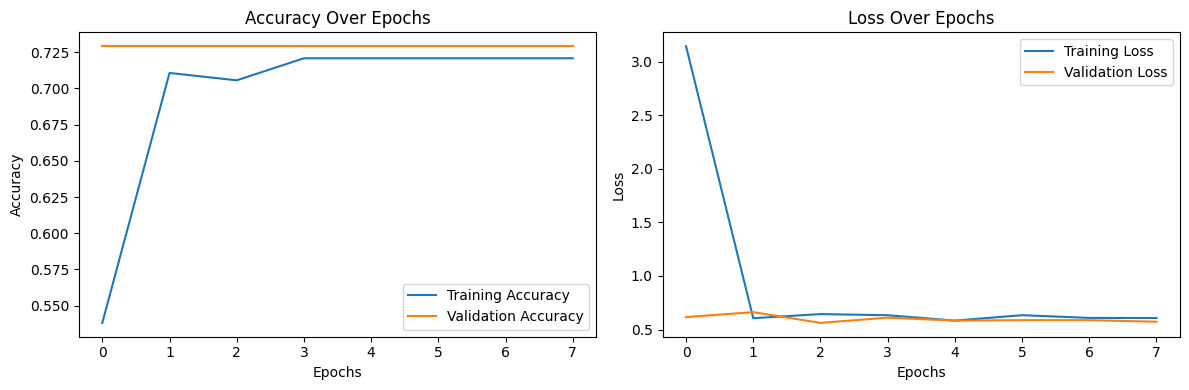

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 495ms/step


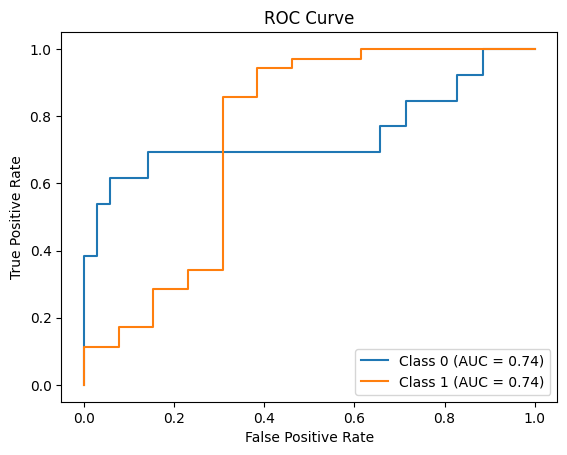

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Directories for training and validation datasets
data_dir = "/content/drive/MyDrive/dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

# Hyperparameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 50

# Data augmentation and generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split data for training and validation
)

train_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.tight_layout()
plt.show()

# Evaluate the model
val_generator.reset()
val_preds = model.predict(val_generator)
y_true = val_generator.classes
y_pred = np.argmax(val_preds, axis=1)

# Compute ROC AUC for each class
plt.figure()
for i in range(train_generator.num_classes):
    y_true_binary = (y_true == i).astype(int)
    y_pred_prob = val_preds[:, i]
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_prob)
    auc_score = roc_auc_score(y_true_binary, y_pred_prob)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Save the model
model.save("chilli_disease_model.h5")


Mounted at /content/drive
Found 197 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training ResNet50...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 352s 32s/step - accuracy: 0.5307 - loss: 1.8111 - val_accuracy: 0.7292 - val_loss: 17.2159 - learning_rate: 0.0010
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 192s 27s/step - accuracy: 0.6449 - loss: 0.6595 - val_accuracy: 0.7292 - val_loss: 101.3238 - learning_rate: 0.0010
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 180s 25s/step - accuracy: 0.7072 - loss: 0.6559 - val_accuracy: 0.7292 - val_loss: 201.4265 - learning_rate: 0.0010
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 188s 26s/step - accuracy: 0.6932 - loss: 0.8122 - val_accuracy: 0.7292 - val_loss: 17.5519 - learning_rate: 0.0010
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 183s 25s/step - accuracy: 0.7327 - loss: 0.6620 - val_accuracy: 0.7292 - val_loss: 7.3422 - learning_rate: 2.0000e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 180s 25s/step - accuracy: 0.6674 - loss: 0.6775 - val_accuracy: 0.7292 - val_loss: 6.4709 - learning_rate: 2.0000e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 193s 27s/step - accuracy: 0.6929 - loss: 0.6174 - val_accurac

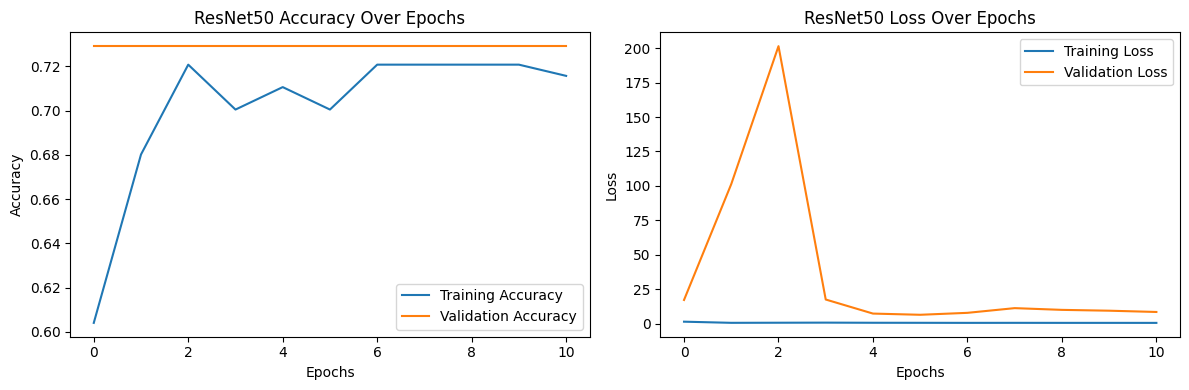

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step


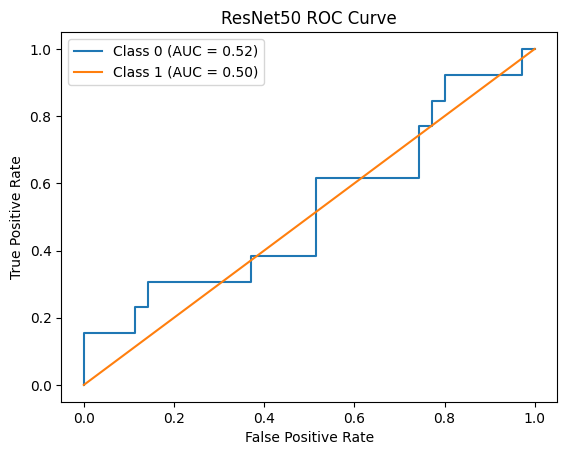

Training InceptionV3...
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 167s 16s/step - accuracy: 0.5113 - loss: 1.0684 - val_accuracy: 0.7292 - val_loss: 1.9757 - learning_rate: 0.0010
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 117s 16s/step - accuracy: 0.6799 - loss: 0.7161 - val_accuracy: 0.7292 - val_loss: 1.8340 - learning_rate: 0.0010
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 140s 16s/step - accuracy: 0.5949 - loss: 0.6982 - val_accuracy: 0.7292 - val_loss: 2.9250 - learning_rate: 0.0010
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 145s 16s/step - accuracy: 0.6306 - loss: 0.6497 - val_accuracy: 0.7292 - val_loss: 15.1739 - learning_rate: 0.0010
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 118s 16s/step - accuracy: 0.7202 - loss: 0.6543 - val_accuracy: 0.5417 - val_loss: 2.1035 - learning_rate: 0.0010
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 139s 15s/step - accuracy: 0.6943 - loss: 0.6097 - val_accuracy: 0.7292 - val_loss: 3.2877 - learning_rate: 2.0000e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 117s 16s/step - accuracy: 0.6911 - 

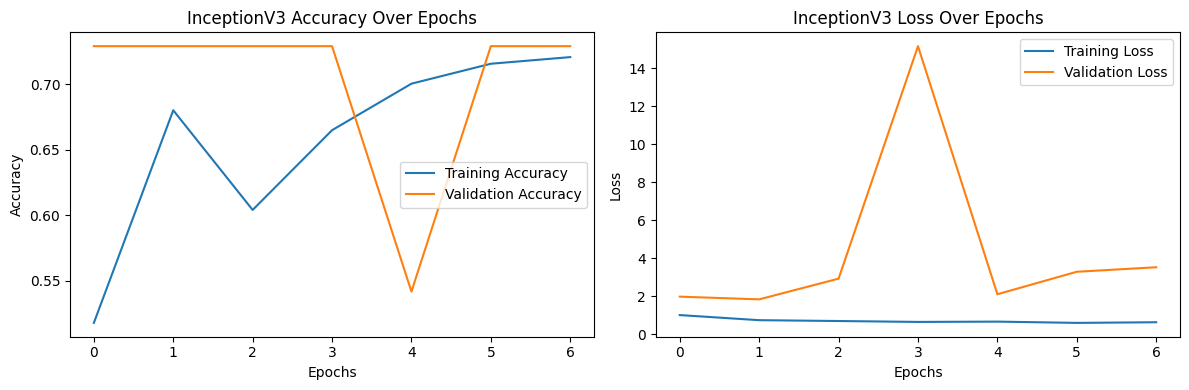

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step


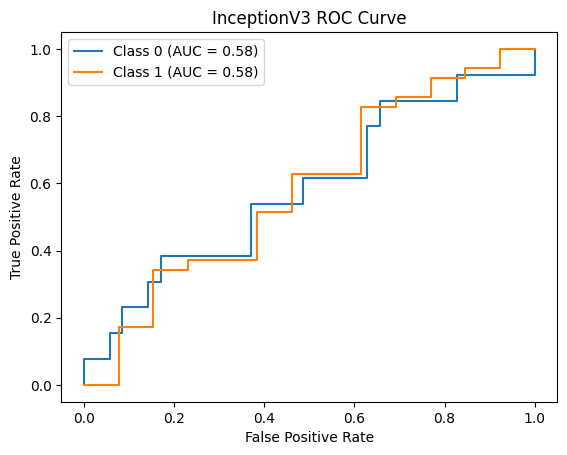

Training EfficientNetB0...
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 130s 11s/step - accuracy: 0.5596 - loss: 0.7947 - val_accuracy: 0.2708 - val_loss: 0.7188 - learning_rate: 0.0010
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 143s 10s/step - accuracy: 0.7367 - loss: 0.5777 - val_accuracy: 0.7292 - val_loss: 0.6488 - learning_rate: 0.0010
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 76s 12s/step - accuracy: 0.6777 - loss: 0.5458 - val_accuracy: 0.2708 - val_loss: 0.8714 - learning_rate: 0.0010
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 79s 10s/step - accuracy: 0.7870 - loss: 0.4729 - val_accuracy: 0.2708 - val_loss: 0.7647 - learning_rate: 0.0010
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 76s 10s/step - accuracy: 0.8066 - loss: 0.4177 - val_accuracy: 0.2708 - val_loss: 0.8495 - learning_rate: 0.0010
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 10s/step - accuracy: 0.8511 - loss: 0.3547 - val_accuracy: 0.2708 - val_loss: 0.9039 - learning_rate: 2.0000e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 75s 11s/step - accuracy: 0.8727 - los

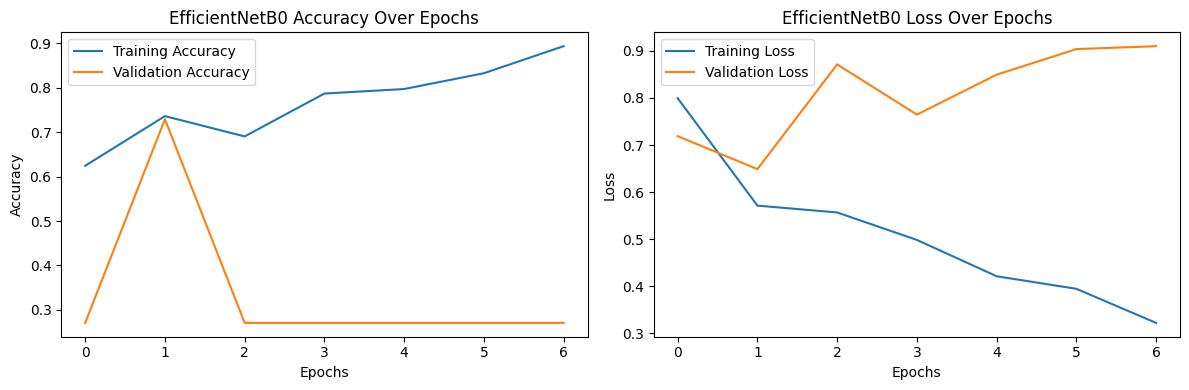

1/2 ━━━━━━━━━━━━━━━━━━━━ 7s 8s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step


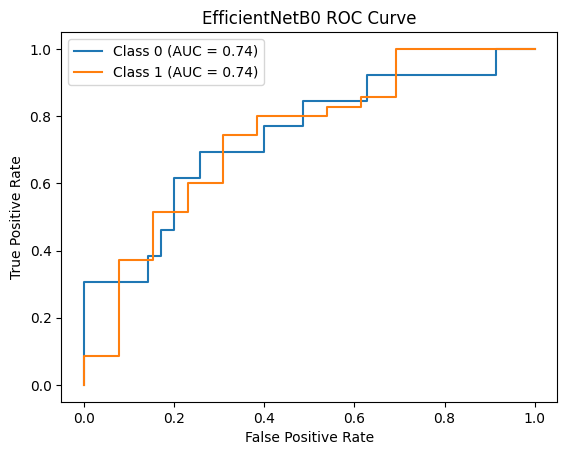

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, InceptionV3, EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/drive')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Directories for training and validation datasets
data_dir = "/content/drive/MyDrive/dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

# Hyperparameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 50

# Data augmentation and generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split data for training and validation
)

train_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# ResNet50 model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
resnet_model = Sequential([
    resnet_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# InceptionV3 model
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
inception_model = Sequential([
    inception_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])
inception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# EfficientNetB0 model
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
efficientnet_model = Sequential([
    efficientnet_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])
efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train and evaluate each model
for model_name, model in zip(['ResNet50', 'InceptionV3', 'EfficientNetB0'], [resnet_model, inception_model, efficientnet_model]):
    print(f"Training {model_name}...")
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr]
    )

    # Plot training history
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{model_name} Accuracy Over Epochs')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} Loss Over Epochs')

    plt.tight_layout()
    plt.show()

    # Evaluate the model
    val_generator.reset()
    val_preds = model.predict(val_generator)
    y_true = val_generator.classes
    y_pred = np.argmax(val_preds, axis=1)

    # Compute ROC AUC for each class
    plt.figure()
    for i in range(train_generator.num_classes):
        y_true_binary = (y_true == i).astype(int)
        y_pred_prob = val_preds[:, i]
        fpr, tpr, _ = roc_curve(y_true_binary, y_pred_prob)
        auc_score = roc_auc_score(y_true_binary, y_pred_prob)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()

    # Save the model
    model.save(f"{model_name.lower()}_model.h5")